In [4]:
from astropy.io import fits
import numpy as np
from astropy.io import fits
import os
import matplotlib.pyplot as plt
from astropy.stats import SigmaClip
from photutils.background import Background2D,SExtractorBackground
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import little_things_functions as ltf
import cv2
#plt.gray()
galaxy_name = 'DDO154'
box_size = 200
window_size = (40, 40)


# import files----------------------------------------------------------------------------------------------------------------------------------------------------
light_file_u = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy\Data\DDO 154\d154u.fits")
light_u = light_file_u[0].data

light_file_b = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy\Data\DDO 154\d154b.fits")
light_b = light_file_b[0].data

light_file_v = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy\Data\DDO 154\d154v.fits")
light_v = light_file_v[0].data

box_u = (100 , 100)
box_b = (130 , 130)
box_v = (170 , 170)

lights = [light_u,light_b,light_v]
boxes = [box_u,box_b,box_v]
filters = ["U" , "B" , "V"]
print(np.shape(light_u), np.shape(light_b), np.shape(light_v))

(1011, 1011) (1011, 1011) (924, 939)


(924, 939) (924, 939) (924, 939)


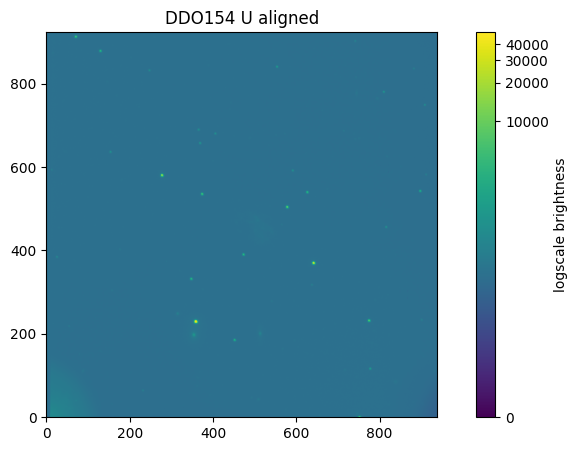

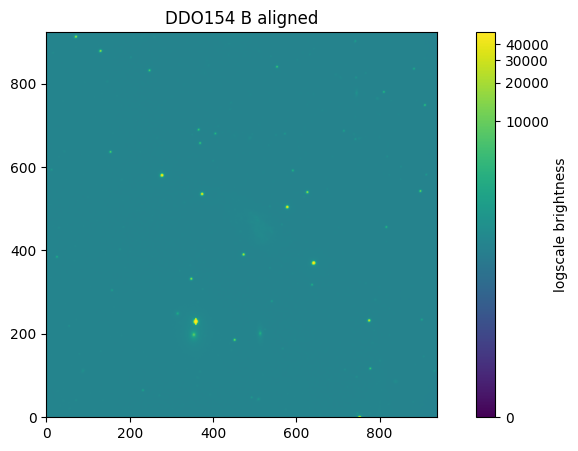

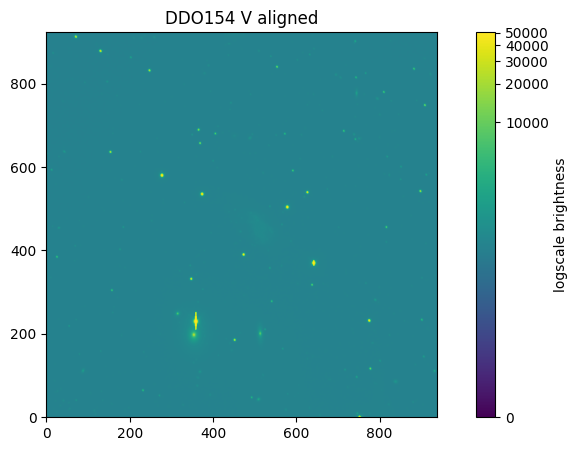

In [6]:
import astroalign as aa
target_fixed = lights[2].byteswap().newbyteorder('N')
source_fixed_1 = lights[0].byteswap().newbyteorder('N')
source_fixed_2 = lights[1].byteswap().newbyteorder('N')

registered_image_1, footprint_1 = aa.register(source_fixed_1, target_fixed)
registered_image_2,  footprint_2 = aa.register(source_fixed_2, target_fixed)
list_of_aligned_images = [registered_image_1, registered_image_2, lights[2] ]

print(np.shape(list_of_aligned_images[1]),np.shape(list_of_aligned_images[2]), np.shape(list_of_aligned_images[2]))
aligned = list_of_aligned_images

for i in range(0,3):
    ltf.log_scale_plot(aligned[i],"%s %s aligned"%(galaxy_name,filters[i]),"logscale brightness")

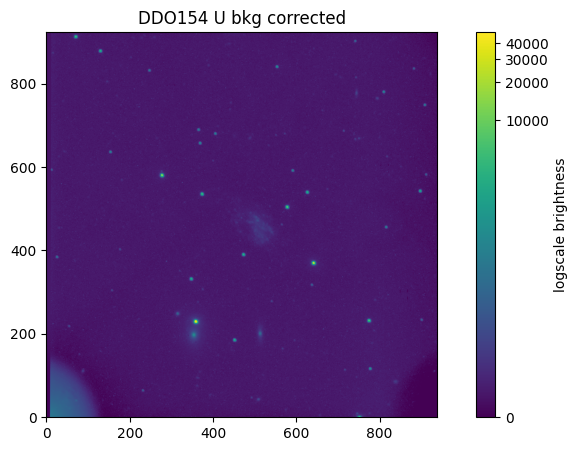

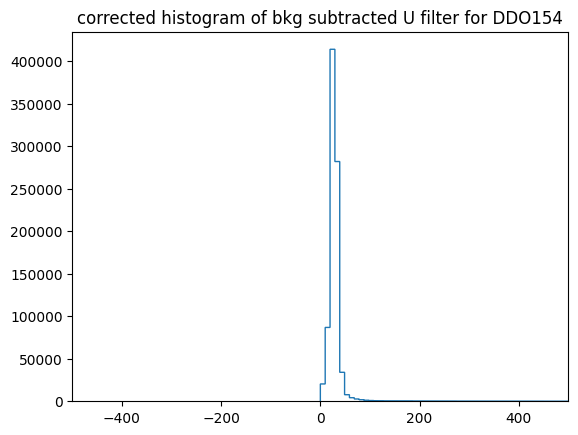

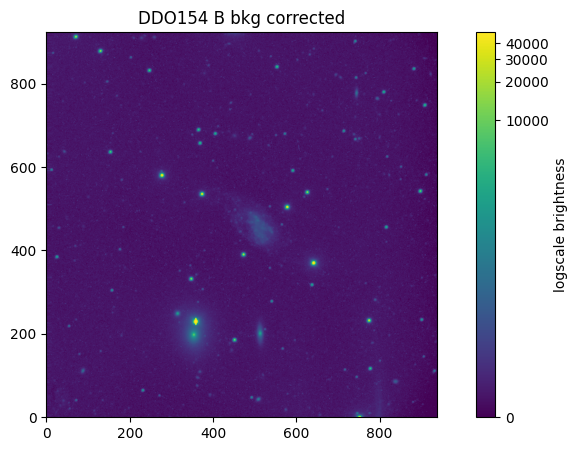

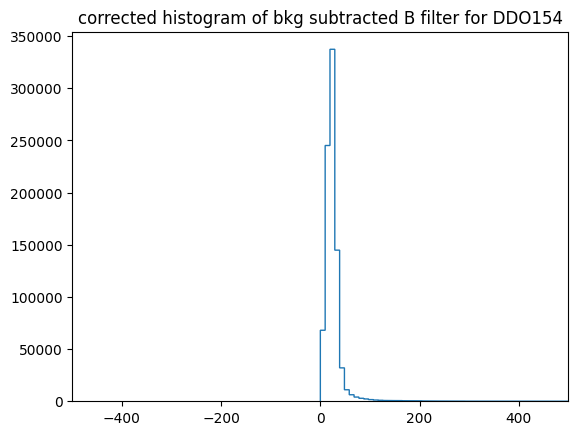

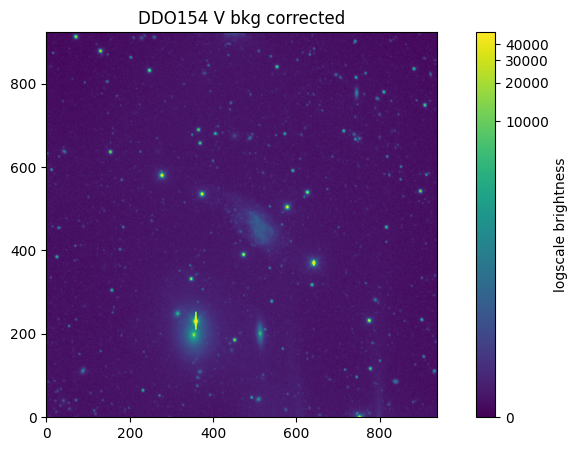

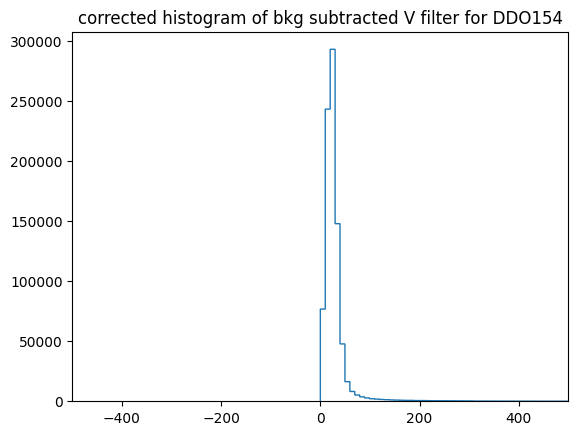

In [7]:
corrected = ltf.background_subtraction(aligned,3,boxes,(3,3))
for i in range(0,3):
    ltf.log_scale_plot(corrected[i],"%s %s bkg corrected"%(galaxy_name,filters[i]),"logscale brightness")
    counts, bins = np.histogram(corrected[i], 5000)
    plt.stairs(counts, bins)
    plt.xlim([-500, 500])
    plt.title("corrected histogram of bkg subtracted %s filter for %s" %(filters[i] , galaxy_name))
    plt.show()

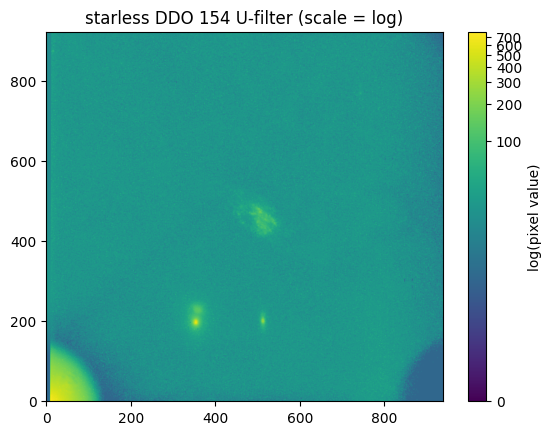

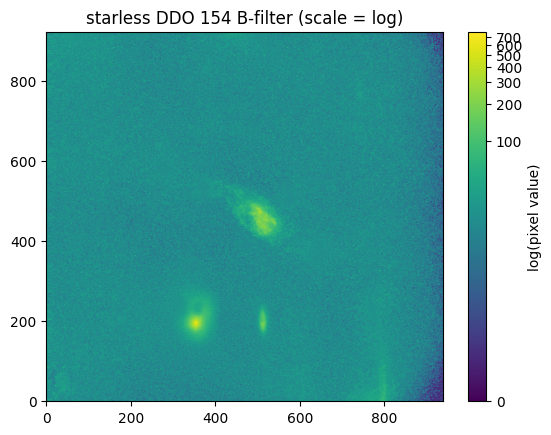

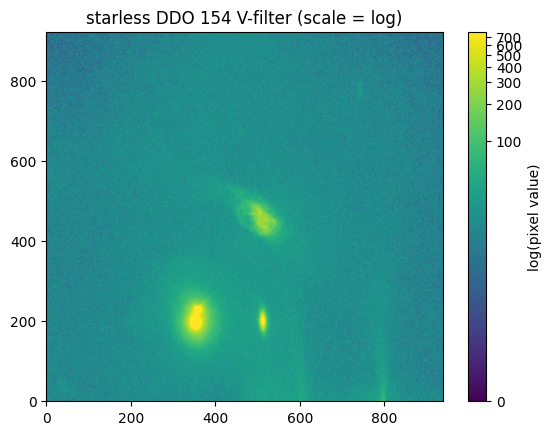

In [8]:
# import starless files----------------------------------------------------------------------------------------------------------------------------------------------------
starless_file_u = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy/Code\d154\DDO 154 starless\starless_DDO154_U_background_subtracted.fit")
starless_u = starless_file_u[0].data
starless_u[starless_u <= 0] = 1
starless_file_b = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy/Code\d154\DDO 154 starless\starless_DDO154_B_background_subtracted.fit")
starless_b = starless_file_b[0].data
starless_b[starless_b <= 0] = 1
starless_file_v = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy/Code\d154\DDO 154 starless\starless_DDO154_V_background_subtracted.fit")
starless_v = starless_file_v[0].data
starless_v[starless_v <= 0] = 1

starless = [starless_u , starless_b , starless_v]

norm = ImageNormalize(vmin=0., stretch=LogStretch())
for i in range(0 , len(starless)):
    
    plt.imshow(starless[i] , origin = "lower" , aspect='auto', norm = norm)
    plt.title('starless DDO 154 %s-filter (scale = log)'%(filters[i]))
    cbar = plt.colorbar()
    cbar.set_label('log(pixel value)')
    plt.show()

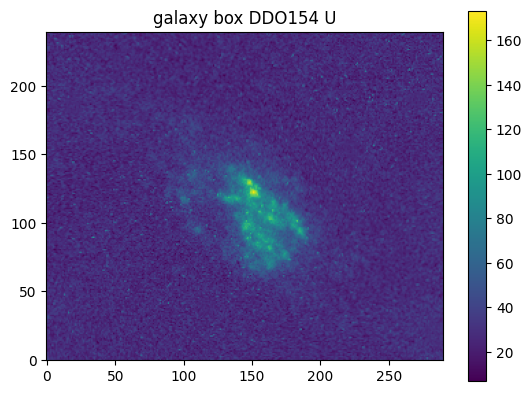

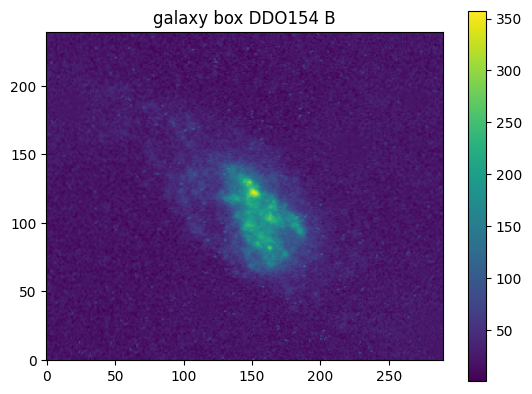

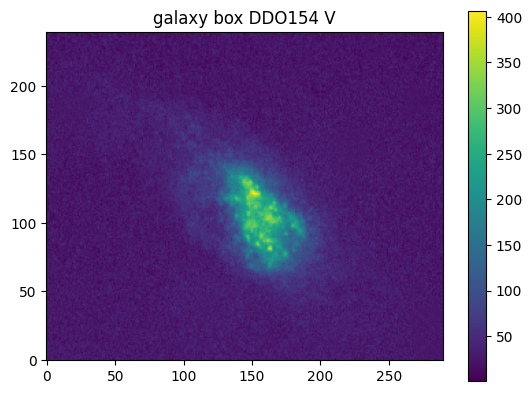

In [48]:
box_size_x = 145
box_size_y = 120
box_center = [500,470]

galaxy_boxes = []
for i in range(0 , len(starless)):
        box = starless[i][box_center[1] - box_size_y : box_center[1] + box_size_y, box_center[0] - box_size_x : box_center[0] + box_size_x]
        galaxy_boxes.append(box)

for i in range(0,3):
    plt.imshow(galaxy_boxes[i], origin = "lower")
    plt.title("galaxy box %s %s"%(galaxy_name,filters[i]))
    plt.colorbar()
    plt.show()
    

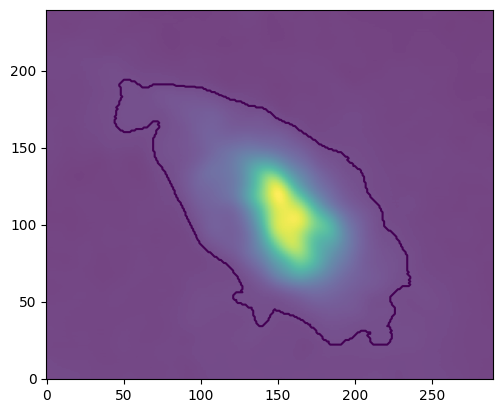

In [49]:
v_value_box = galaxy_boxes[2]
contour_points = ltf.contour_lines_coordinates(v_value_box, 5, [32])
x_points , y_points = contour_points

(113.03102859655448, 146.90155429041872)
[147.66091445 108.98125324 111.64260379  52.87688745  -0.75481671]


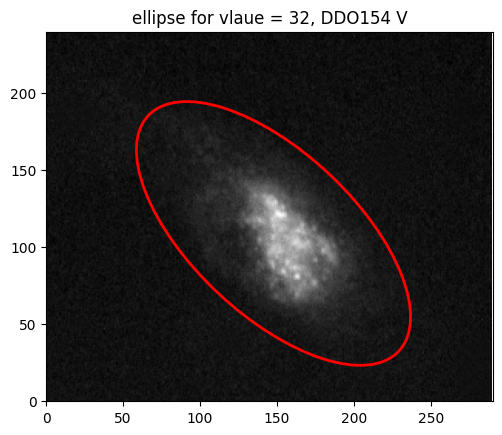

In [50]:
image_center_of_mass = ndimage.center_of_mass(v_value_box)
print(image_center_of_mass)
#coordinates
x, y = image_center_of_mass[1], image_center_of_mass[0]
from scipy.ndimage import gaussian_filter
import cv2
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse
initial_guess = [x, y, (max(x_points) - min(x_points)) / 2 , (max(y_points) - min(y_points)) / 2 , 0]
popt, pcov = curve_fit(ltf.ellipse, (x_points, y_points), np.zeros_like(x_points), p0=initial_guess)
stdv=np.sqrt(np.diag(pcov))
stdvx=stdv[0]
stdvy=stdv[1]
stdva=stdv[2]
stdvb=stdv[3]
stdvpa=stdv[4]

xc, yc, a, b, theta = popt

curve = ltf.ellipse(x_points,popt[0],popt[1],popt[2],popt[3],popt[4])

xc, yc, a, b, theta = popt
print(popt)
# Create a figure and axis
plt.figure()
ax = plt.gca()

# Display the other image
ax.imshow(v_value_box, cmap='gray' , origin = "lower")

# Create the ellipse
ellipse = Ellipse(xy=(xc, yc), width=2*a, height=2*b, angle=np.degrees(theta), edgecolor='r', facecolor='none', linewidth=2)

# Add the ellipse to the axis
ax.add_patch(ellipse)

# Set axis limits (adjust as needed)
ax.set_xlim(0,v_value_box.shape[1])
ax.set_ylim(0,v_value_box.shape[0])  # Reverse y-axis for imshow
plt.title("ellipse for vlaue = 32, DDO154 V")
# Show the plot
plt.show()

C:\Users\AYSAN\AppData\Local\Temp\ipykernel_5316\1008961382.py:3: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please use `from photutils.aperture import aperture_photometry` to silence this warning.
  from photutils import aperture_photometry


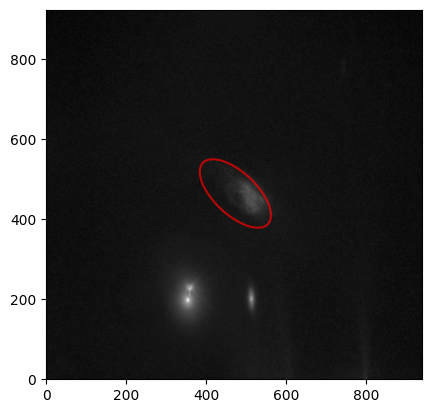

In [72]:
from astropy.coordinates import Angle
from photutils.aperture import EllipticalAperture
from photutils import aperture_photometry
elliptical_center_box = (xc,yc)
new_xc = xc + (box_center[1]-box_size_x)
new_yc = yc + (box_center[0]-box_size_y)
elliptical_center = (new_xc,new_yc)
ellipse_aper = EllipticalAperture(elliptical_center, a, b, theta)
norm = ImageNormalize(vmin=0., stretch=LogStretch())
plt.imshow(starless[2], cmap='gray', origin = "lower" , norm = norm) 
ellipse_aper.plot(color='red', lw=1.5, alpha=0.7) 
plt.show()
phot_table = aperture_photometry(starless[2], ellipse_aper)
aperture_sum_A = phot_table['aperture_sum'][0] 

C:\Users\AYSAN\AppData\Local\Temp\ipykernel_5316\2676321127.py:3: DeprecationWarning: `photutils.EllipticalAperture` is a deprecated alias for `photutils.aperture.EllipticalAperture` and will be removed in the future. Instead, please use `from photutils.aperture import EllipticalAperture` to silence this warning.
  from photutils import EllipticalAperture, aperture_photometry
C:\Users\AYSAN\AppData\Local\Temp\ipykernel_5316\2676321127.py:3: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please use `from photutils.aperture import aperture_photometry` to silence this warning.
  from photutils import EllipticalAperture, aperture_photometry


Aperture sums: [4.712388980384691e-10, 436.3307614529341, 1738.109547465543, 3909.45147960183, 6965.381159618956, 10776.274534231896, 15355.758089911264, 20770.603141987976, 27025.631647231967, 34061.716662477746, 42100.218565092015, 51012.578036503655, 60723.388757395944, 71230.27178625169, 82357.26358608966, 93818.76557857245, 105838.53948402229, 118820.1200307892, 132738.4426752794, 147407.54870474574, 162558.9558370468, 177901.85819302013, 193535.7769582266, 209683.13121231197, 226286.7921186712, 243248.05368298176, 260492.68077677998, 278172.59387164115, 296334.3116449916, 315398.844052048, 335458.08642007137, 355924.6446244999, 376306.7060129958, 396895.3681714244, 417681.98045608227, 439115.0254666151, 461330.55881262023, 483916.09067675774, 506186.97670433717, 528432.6599398846, 550663.4955267704, 573058.2955537847, 595355.2858947478, 617562.7753624802, 640045.6601275953, 662943.1785628889, 686025.1170605047, 708724.4372421757, 731516.5740271535, 754387.4349907115, 777037.03408

Text(0.5, 1.0, ' curve of growth for DDO154')

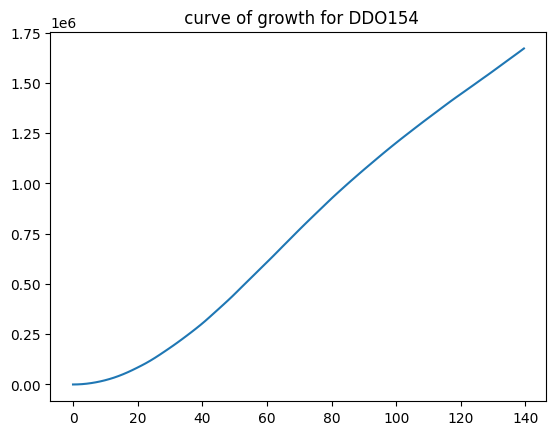

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from photutils import EllipticalAperture, aperture_photometry

# Assuming you have defined 'a', 'b', 'theta', 'elliptical_center', and 'v_value_box'
ab_ratio = a / b
ba_ratio = b / a
a_list = np.linspace(0, 1.25* a, 100)
b_list = ba_ratio * a_list

sum_values = []

for i in range(len(a_list)):
    # Ensure positive scalar values for major and minor axes
    a_i = max(a_list[i], 1e-6)  # Avoid zero or negative values
    b_i = max(b_list[i], 1e-6)
    ellipse_aper = EllipticalAperture(elliptical_center, a_i, b_i, theta)
    '''
    plt.imshow(starless[2], cmap='gray')  # Replace 'image_data' with your data
    ellipse_aper.plot(color='red', lw=1.5, alpha=0.7)  # Overlay the aperture
    plt.show()
    '''
    # Compute the aperture sum
    phot_table = aperture_photometry(starless[2], ellipse_aper)
    aperture_sum_A = phot_table['aperture_sum'][0]
    sum_values.append(aperture_sum_A)

print("Aperture sums:", sum_values)

plt.plot(a_list , sum_values)
plt.title(" curve of growth for DDO154")

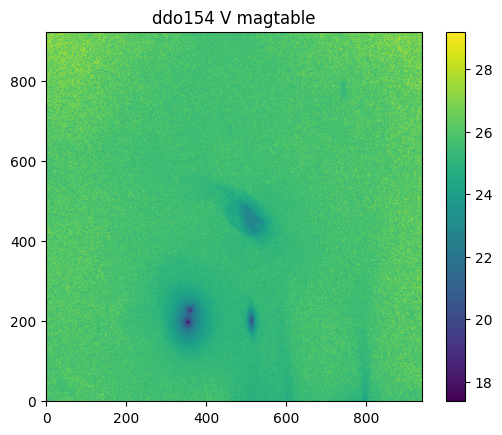

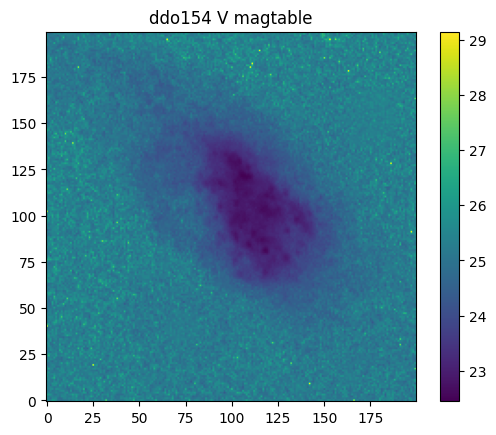

In [7]:
airmass_values=[1.16, 1.49, 1.11]
pixel_scale = 1.134
exposures = [1800, 1200, 600]
mU_values = [5.196, 0.4683865, -0.093,  0.]
mB_values = [3.562, 0.2586217, -0.0166, 0.]
mV_values = [3.017, 0.128904 ,  0.045,  0.]
m_values = [mU_values,mB_values,mV_values]

plt.imshow(ltf.mag_table_correction(starless,airmass_values,m_values,pixel_scale,exposures)[2] , origin="lower")
plt.title("ddo154 V magtable")
plt.colorbar()
plt.show()

plt.imshow(ltf.mag_table_correction(galaxy_boxes,airmass_values,m_values,pixel_scale,exposures)[2] , origin="lower")
plt.title("ddo154 V magtable")
plt.colorbar()
plt.show()

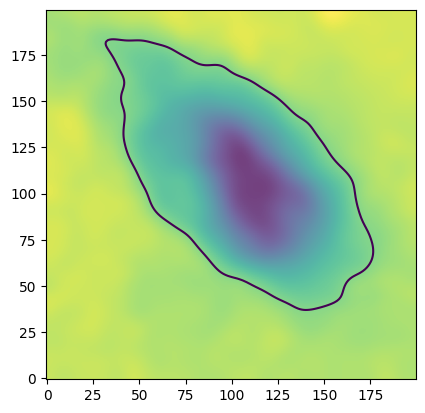

In [8]:
v_box = ltf.mag_table_correction(galaxy_boxes,airmass_values,m_values,pixel_scale,exposures)[2]
contour_points = ltf.contour_lines_coordinates(v_box, 5, [25])
x_points , y_points = contour_points

In [9]:
image_center_of_mass = ndimage.center_of_mass(v_box)
print(image_center_of_mass)
#coordinates
x, y = image_center_of_mass[1], image_center_of_mass[0]

(99.45652097762529, 99.36669895573858)


[104.56636068 109.52377357  44.49206359  89.36009418   7.06629674]


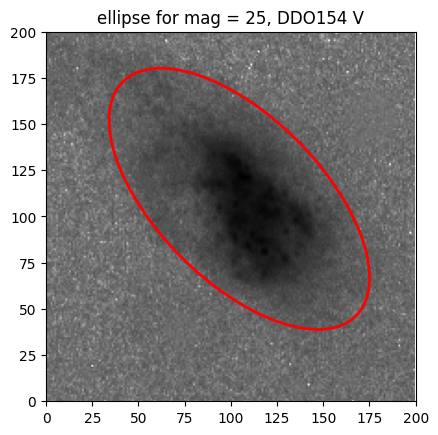

In [11]:
from scipy.ndimage import gaussian_filter
import cv2
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse

initial_guess = [x, y, (max(x_points) - min(x_points)) / 2 , (max(y_points) - min(y_points)) / 2 , 0]
popt, pcov = curve_fit(ltf.ellipse, (x_points, y_points), np.zeros_like(x_points), p0=initial_guess)
stdv=np.sqrt(np.diag(pcov))
stdvx=stdv[0]
stdvy=stdv[1]
stdva=stdv[2]
stdvb=stdv[3]
stdvpa=stdv[4]

xc, yc, a, b, theta = popt

curve = ltf.ellipse(x_points,popt[0],popt[1],popt[2],popt[3],popt[4])

xc, yc, a, b, theta = popt
print(popt)
# Create a figure and axis
plt.figure()
ax = plt.gca()

# Display the other image
ax.imshow(v_box, cmap='gray' , origin = "lower")

# Create the ellipse
ellipse = Ellipse(xy=(xc, yc), width=2*a, height=2*b, angle=np.degrees(theta), edgecolor='r', facecolor='none', linewidth=2)

# Add the ellipse to the axis
ax.add_patch(ellipse)

# Set axis limits (adjust as needed)
ax.set_xlim(0,v_box.shape[1])
ax.set_ylim(0,v_box.shape[0])  # Reverse y-axis for imshow
plt.title("ellipse for mag = 25, DDO154 V")
# Show the plot
plt.show()